In [12]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# **Load the training data**

We load the training data.

In [1]:
import datetime
from implementations import *

data_load = load_data("x_train.csv")
pred = load_data("y_train.csv")
print(f"The data has {data_load.shape[0]} samples and {data_load.shape[1]} features !")

The data has 328135 samples and 321 features !


We clean the data by removing the nan values by the mean of the rest of the feature

In [2]:
data = np.ones(data_load.shape)
stds = np.array([])
for i in range(data.shape[1]):
    d, std = standardize_clean(data_load[:, i])
    data[:, i] = d
    stds = np.append(stds, std)
print(stds.shape)

(321,)


We further clean the data by removing the features where the variance is zero since they are constants for all samples

In [3]:
indices = np.where(stds != 0)
data_var = data[:, indices]
data_var = np.squeeze(data_var, axis = 1)
print(data_var.shape)

(328135, 315)


We also remove the 8 first features as the appear weird in the task of predicting a heart attack

In [5]:
data_cleaned = data_var[:, 9:]
print(data_cleaned.shape)

(328135, 306)


We then separe the data to train on 60% of the total and to test it on the remaining 40% 

In [6]:
train_size = np.floor(data_cleaned.shape[0] * 0.6).astype(int)
data_cross = data_cleaned[:train_size, :]
pred_cross = pred[:train_size]
data_test = data_cleaned[train_size:, :]
pred_test = pred[train_size:]
print(f"Cross shape : {data_cross.shape} ; Test shape : {data_test.shape}")

Cross shape : (196881, 306) ; Test shape : (131254, 306)


Now we build our models for linear regression

In [7]:
y, tx = build_model_data(data_cross, pred_cross)
y_test, tx_test = build_model_data(data_test, pred_test)
print(f"The data has now {tx.shape[1]} features !")

The data has now 307 features !


## Least-squares

Here we train our model using the least-squares equations

In [8]:
start_time = datetime.datetime.now()
w, loss = least_squares(y, tx)
end_time = datetime.datetime.now()
print(f"Execution time {(end_time - start_time).total_seconds()} seconds with loss : {loss}")

Execution time 0.168606 seconds with loss : 0.03381118428465108


### Computation of metrics

We first compute some metrics on the training data (60% of the total data)

In [9]:
pred_data = np.dot(tx, w)
pred_data = (pred_data > 0.49).astype(float)
correctly_classified_data = np.sum(pred_data == y)

tp = np.sum((pred_data == 1) & (y == 1))
fp = np.sum((pred_data == 1) & (y == 0))

tn = np.sum((pred_data == 0) & (y == 0))
fn = np.sum((pred_data == 0) & (y == 1))

accuracy_data = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_data*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")

Accuracy: 91.2886464412513%
True positive rate: 67.11711711711712%
True negative rate: 91.3159326550018%


Now we compute some metrics for our test data (40% of the total data)

In [10]:
pred_test = np.dot(tx_test, w)
pred_test = (pred_test > 0.49).astype(float)
correctly_classified_test = np.sum(pred_test == y_test)

tp = np.sum((pred_test == 1) & (y_test == 1))
fp = np.sum((pred_test == 1) & (y_test == 0))

tn = np.sum((pred_test == 0) & (y_test == 0))
fn = np.sum((pred_test == 0) & (y_test == 1))

accuracy_test = (tp + tn)/(tp + fp + tn + fn)

print(f"Accuracy: {accuracy_test*100}%")
print(f"True positive rate: {tp/(tp + fp)*100}%")
print(f"True negative rate: {tn/(tn + fn)*100}%")

Accuracy: 91.09131912170297%
True positive rate: 66.08187134502924%
True negative rate: 91.12394437112364%


### Feature analysis

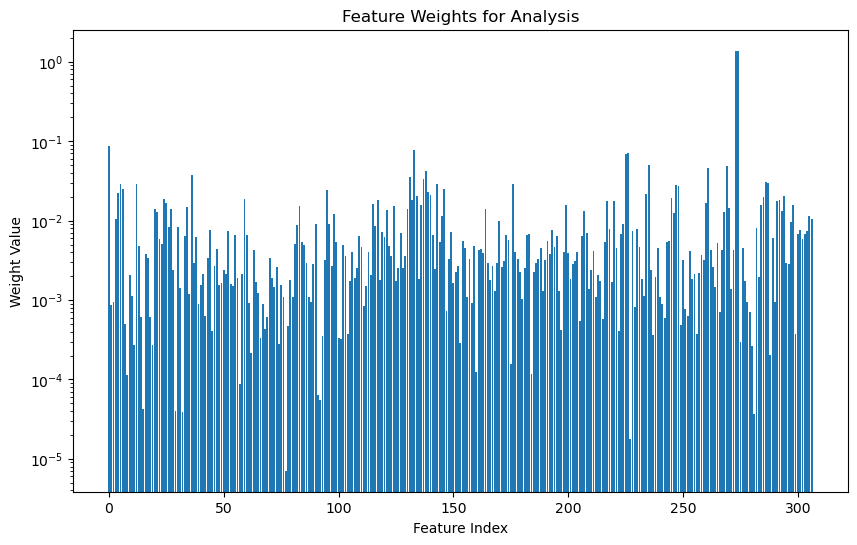

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(w)), np.abs(w))
plt.yscale('log')
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Feature Weights for Analysis')
plt.show()